<a href="https://colab.research.google.com/github/LuisHenrique7/Scrapping/blob/main/scraping_casas_olx.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Bibliotecas

In [1]:
import pandas as pd
import numpy as np
import requests
from bs4 import BeautifulSoup
import time
from time import sleep
import random
from datetime import date, timedelta, datetime
import re

In [2]:
import matplotlib.pyplot as plt
# from IPython.display import Image
from PIL import Image
from io import BytesIO

# Funções

In [3]:
def ImoveisVendaOLX(pages, regiao):

  lista = []

  """
  Retorna um pandas dataframe com anuncios publicados na olx. Itera por N pages e nas regioes:
  AJU - Imoveis para venda em Araju
  SE-OUTRAS - Imoveis para venda em outras cidades de Sergipe
  """
  RegiaoBuscar = {"AJU" : "sergipe/aracaju", "SE-OUTRAS" : "sergipe/outras-cidades"}
  prefix = {"AJU" : "se", "SE-OUTRAS" : "se"}
  cidade = {"AJU" : "Aracaju,", "SE-OUTRAS" : ""} #dict pra remover o nome da cidade do bairro/região

  ConvMes = {"jan" : "jan",
             "fev" : "feb",
             "mar" : "mar",
             "abr" : "apr",
             "mai" : "may",
             "jun" : "jun",
             "jul" : "jul",
             "ago" : "aug",
             "set" : "sep",
             "out" : "oct",
             "nov" : "nov",
             "dez" : "dec",
  }
  
  for x in range(0, pages):

    sleep(random.randint(0,2))

    print(f'Página n°:{x}')
    url = "https://" + prefix[regiao] + ".olx.com.br/" + RegiaoBuscar[regiao] + "/imoveis/venda/casas"

    if x == 0:
      print(f'Página n°:{x}')
    else:
      url = "https://" + prefix[regiao] + ".olx.com.br/" + RegiaoBuscar[regiao] + "/imoveis/venda/casas?o=" + str(x)

    PARAMS = {
              "autorithy" : "se.olx.com.br",
              "method": "GET",
              "path": "", #"/sergipe/aracaju/imoveis/venda",
              "scheme": "https",
              "referer": "", 
              "sec-fetch-mode":"navigate",
              "sec-fetch-site":"same-origin",
              "sec-fetch-user":"?1",
              "upgrade-insecure-requests": "1",
              "user-agent": 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/79.0.3945.130 Safari/537.36',
              }

    page = requests.get(url = url, headers = PARAMS)
    soup = BeautifulSoup(page.content, 'lxml')
    itens = soup.find_all("li", {"class": "sc-1fcmfeb-2 fvbmlV"}) #primeiro item: sc-1fcmfeb-2 OgCqv / Itens do meio: sc-1fcmfeb-2 juiJqh / item final: sc-1fcmfeb-2 cfLiFC
    # count = 0
    for a in itens:
      # print(a, '\n') # teste
      try:
        TituloImovel = a.find_all("h2")[0].contents[0]
        # print(f"Título: {TituloImovel}") # teste
        # count += 1
        # print(a.find_all("span", class_="m7nrfa-0 cjhQnm sc-ifAKCX kaNiaQ")[0].contents[0]) # teste
        # print(a, '\n') # teste
        Preco = a.find_all("span", class_="sc-ifAKCX eoKYee")[0].contents[0]
        Preco = Preco.split("R$")[1]
        Preco = float(Preco.replace(".",""))
        # print(f"P1 - Preço = {Preco}") # teste
        Data = a.find_all("span", class_="wlwg1t-1 fsgKJO sc-ifAKCX eLPYJb")[0].contents[0].split(', ')[0]
        # print("P2 - ", end='') # teste
        if Data == "Hoje":
          Data = Data.replace("Hoje",str((datetime.now()-timedelta(hours=3)).date().strftime("%d/%m/%Y")))
        else:
          Data = Data
        
        if Data == "Ontem":
          Data = Data.replace("Ontem",str(((datetime.now()-timedelta(hours=27)).date()).strftime("%d/%m/%Y")))
        else:
          Data = Data

        if len(Data) == 5 or len(Data) == 6:
          Data = Data.replace(Data[-3:],ConvMes[Data[-3:]])
          Data = Data + " 2022"
          Data = datetime.strptime(Data, '%d %b %Y')
          Data = datetime.strftime(Data, '%d/%m/%Y')
        else:
          Data = Data

        # print(f"Data: {Data}") # teste
        # print(a.find_all("span", class_="sc-11h4wdr-0 cHSTFT sc-ifAKCX cmFKIN")[0].contents) # teste
        Hora = a.find_all("span", class_="wlwg1t-1 fsgKJO sc-ifAKCX eLPYJb")[1].contents[0]
        # print(f"P3 - Hora = {Hora}") # teste
        Link = a.find("a")["href"]
        # print(f"P4 - Link = {Link}") # teste
        Bairro = a.find_all("span", class_="sc-7l84qu-1 ciykCV sc-ifAKCX dpURtf")[0].contents[0]
        Bairro = Bairro.strip()
        Bairro = Bairro.replace(cidade[regiao],"")
        # print(f"P5 - Bairro = {Bairro}") # teste

        page_interna = requests.get(url = Link, headers = PARAMS)
        soup_interna = BeautifulSoup(page_interna.content, 'lxml')
        itens_internos = soup_interna.find_all("div", {"class": "sc-hmzhuo sc-1f2ug0x-3 ONRJp sc-jTzLTM iwtnNi"})
        # print(f"P6 - itens_internos = {itens_internos}") # teste
        
        labels = soup_interna.find_all(class_="sc-1f2ug0x-0 cLGFbW sc-ifAKCX cmFKIN") # tag dt
        contents = soup_interna.find_all(class_="sc-1f2ug0x-1 ljYeKO sc-ifAKCX kaNiaQ") # tag dd

        rotulos = []
        conteudo = []
        index_aux = 0

        # OBS labels possui 2 itens iniciais que não são referentes aos 2 primeiros itens de contents
        # por isso o for parte do indice 2
        for i in range(2, len(labels)): 
          # Captura apenas a string essêncial da tag para montar a lista de rótulos (tag dt) e conteúdo (tag dd)
          rot = str(labels[i]).replace('<dt class="sc-1f2ug0x-0 cLGFbW sc-ifAKCX cmFKIN" color="dark" font-weight="400">', '').replace('</dt>', '')
          rotulos.append(rot)
          if index_aux < len(contents):
            con = str(contents[index_aux]).replace('<dd class="sc-1f2ug0x-1 ljYeKO sc-ifAKCX kaNiaQ" color="dark" font-weight="400">', '').replace('</dd>', '')
            index_aux += 1
            conteudo.append(con)

        # print("P7") # teste
        # labels pode possuir o rótulo "Quartos" que também não se encaixa com os itens de contents,
        # por isso será removido
        if 'Quartos' in rotulos:
          rotulos.remove('Quartos')

        IPTU = ''
        detalhes_imovel = ''
        detalhes_condominio = ''
        count_content = 0

        # Percorre as listas rotulos e conteudo para capturar os itens desejados
        for i in range(0, len(rotulos)):
          # Caso já tenha pego os 3 conteúdos desejados para o laço
          if count_content == 3:
            break

          if rotulos[i] == 'IPTU':
            IPTU = conteudo[i].strip('R$ ').replace('.', '').replace(',', '.')
            IPTU = float(IPTU)
            count_content += 1
          elif rotulos[i] == 'Detalhes do imóvel':
            detalhes_imovel = conteudo[i]
            count_content += 1
          elif rotulos[i] == 'Detalhes do condominio':
            detalhes_condominio = conteudo[i]
            count_content += 1

        # print(a.find_all("span", class_="sc-1ftm7qz-0 itsfPe sc-ifAKCX cmFKIN"))
        Dados_bruto = a.find_all("span", class_="sc-1j5op1p-0 lnqdIU sc-ifAKCX eLPYJb")
        Dados = ""
        for d in Dados_bruto:
          Dados += d.contents[0]
        Dados = Dados.strip()
        Dados = Dados.replace(".","")
        # print(f"P8 - Dados = {Dados}") # teste
        try:
          Quartos = re.split("(\d+)(.+quarto)",Dados)[1]
        except:
          Quartos = ""

        try:
          Area = re.split("(\d+)(m²)",Dados)[1]
        except:
          Area = ""

        try:
          TaxaCond = re.split("(R\$) (\d+)",Dados)[2]
        except:
          TaxaCond = ""

        try:
          VagasGaragem= re.split("(\d+)(.+vaga)",Dados)[1]
        except:
          VagasGaragem = ""  
        # print(f"Quartos = {Quartos}, Area = {Area}, Taxa Condom = {TaxaCond}, Vagas = {VagasGaragem}\n") # teste

        olx = {"Anuncio" : TituloImovel,
                    "Preco" : Preco,
                    "Data" : Data,
                    "Hora" : Hora,
                    "Link" : Link,
                    "Localidade" : Bairro,
                    "Quartos" : Quartos,
                    "Area" : Area,
                    "TaxaCond" : TaxaCond,
                    "VagasGaragem" : VagasGaragem,
                    "IPTU": IPTU,
                    "Detalhes do imóvel" : detalhes_imovel,
                    "Detalhes do condominio": detalhes_condominio
                    }
        lista.append(olx)


      except:
        next
  # print(count)
  return pd.DataFrame(lista)

In [4]:
def CapturaImagens(lista_links):
  lista_imagens = []
  num_img_por_imovel = []

  for i in lista_links[: len(lista_links)]:
    try:
      url = i

      PARAMS = {
                  "autorithy" : "se.olx.com.br",
                  "method": "GET",
                  "path": "", #"/sergipe/aracaju/imoveis/venda",
                  "scheme": "https",
                  "referer": "", 
                  "sec-fetch-mode":"navigate",
                  "sec-fetch-site":"same-origin",
                  "sec-fetch-user":"?1",
                  "upgrade-insecure-requests": "1",
                  "user-agent": 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/79.0.3945.130 Safari/537.36',
                  }

      html_page = requests.get(url = url, headers = PARAMS)
      
      soup = BeautifulSoup(html_page.content, 'html.parser')
      imgs = soup.find_all('img', class_="image ")

      image_list = []
      for img in imgs:
        sleep(random.randint(0,2))
        imgurl = img.get('src')
        response = requests.get(imgurl)
        img = Image.open(BytesIO(response.content))
        lista_imagens.append(img)

      num_img_por_imovel.append(len(imgs))
    except:
      next
    
  return lista_imagens, num_img_por_imovel



# Carregando Anúncios

## Ler arquivo atual do drive

In [ ]:
# Ler arquivo atual do drive

df_CasasAJUComDetalhes = pd.read_csv('/content/drive/MyDrive/PIBIC/Precificando casas OLX/Dados Capturados/df_CasasAJUComDetalhes.csv', header=0)

print(len(df_CasasAJUComDetalhes))

237


In [ ]:
df_CasasAJUComDetalhes.head()

,Anuncio,Preco,Data,Hora,Link,Localidade,Quartos,Area,TaxaCond,VagasGaragem,IPTU,Detalhes do imóvel,Detalhes do condominio
0,Casa no Bairro Suíssa- Próximo a Hermes Fontes,730000.0,21/04/2022,20:03,https://se.olx.com.br/sergipe/imoveis/casa-no-...,Suíssa,5.0,263.0,NaN,2.0,NaN,"Armários embutidos, Varanda, Área de serviço, ...","Área murada, Portão eletrônico"
1,Casa para venda possui 200 metros quadrados co...,290000.0,21/04/2022,20:01,https://se.olx.com.br/sergipe/imoveis/casa-par...,Cidade Nova,4.0,200.0,0.0,NaN,0.0,NaN,NaN
2,Casa de condomínio fechado no Morada das Mangu...,800000.0,21/04/2022,19:50,https://se.olx.com.br/sergipe/imoveis/casa-de-...,Ponto Novo,4.0,21.0,3600003.0,3600003.0,0.0,NaN,NaN
3,Oportunidade de casa próximo à Orla Por do Sol,220000.0,21/04/2022,19:42,https://se.olx.com.br/sergipe/imoveis/oportuni...,Zona de Expansão (Mosqueiro),2.0,400.0,NaN,NaN,NaN,"Área de serviço, Churrasqueira, Varanda",NaN
4,Condomínio Praias do Sul I,950000.0,21/04/2022,19:37,https://se.olx.com.br/sergipe/imoveis/condomin...,Atalaia,4.0,360.0,5.0,NaN,0.0,Piscina,"Piscina, Permitido animais"


## Faz o scraping de novos dados

In [ ]:
# Faz o scraping de novos dados
df = ImoveisVendaOLX(2, "AJU")

Página n°:0
Página n°:0
Página n°:1


In [ ]:
print(len(df))

94


In [ ]:
df.drop_duplicates(subset=['Anuncio','Preco','Localidade'],inplace=True)
print(len(df))

47


In [ ]:
# Quantos imóveis novos foram coletados
copia = df_CasasAJUComDetalhes.copy()
copia = copia.append(df)
copia.drop_duplicates(subset=['Anuncio','Preco','Localidade'],inplace=True)
print(len(copia))
print(len(copia) - len(df_CasasAJUComDetalhes))

280
43


In [ ]:
df

,Anuncio,Preco,Data,Hora,Link,Localidade,Quartos,Area,TaxaCond,VagasGaragem,IPTU,Detalhes do imóvel,Detalhes do condominio
0,Casa para venda com 102m2 com 4/4 em Santo Ant...,300000.0,11/05/2022,23:10,https://se.olx.com.br/sergipe/imoveis/casa-par...,Santo Antônio,4,102,0,4,0.0,Mobiliado,Permitido animais
1,Casa no Cond. Morada do Rio,2800000.0,11/05/2022,23:09,https://se.olx.com.br/sergipe/imoveis/casa-no-...,Zona de Expansão (Robalo),5,800,500,5,0.0,"Porteiro 24h, Mobiliado, Área de serviço, Pisc...","Portão eletrônico, Condomínio fechado, Permiti..."
2,Casa no Condomínio Lago Paronoa,2500000.0,11/05/2022,23:08,https://se.olx.com.br/sergipe/imoveis/casa-no-...,Zona de Expansão (Mosqueiro),4,750,0,4,0.0,"Área de serviço, Quarto de serviço, Varanda, P...","Portão eletrônico, Piscina, Condomínio fechado..."
3,Casa no Grageru - Rua Terêncio,760000.0,11/05/2022,22:56,https://se.olx.com.br/sergipe/imoveis/casa-no-...,Grageru,3,240,0,3,0.0,,
4,Casa de Alto Padrão na Atalaia,1230000.0,11/05/2022,22:56,https://se.olx.com.br/sergipe/imoveis/casa-de-...,Atalaia,3,225,0,3,0.0,,
5,Casa e Ponto comercial na Gentil Tavares - Siq...,980000.0,11/05/2022,22:56,https://se.olx.com.br/sergipe/imoveis/casa-e-p...,Siqueira Campos,4,230,0,4,1781.0,,Permitido animais
6,"Casa com 3 quartos, à venda",530000.0,11/05/2022,22:53,https://se.olx.com.br/sergipe/imoveis/casa-com...,Zona de Expansão (Robalo),3,150,0,,0.0,,
7,Casa no Conjunto Costa e Silva perto da Rua Acre,290000.0,11/05/2022,22:49,https://se.olx.com.br/sergipe/imoveis/casa-no-...,Ponto Novo,2,198,0,2,0.0,Área de serviço,
8,Casa à Venda no Bairro Ponto Novo.,500000.0,11/05/2022,22:43,https://se.olx.com.br/sergipe/imoveis/casa-a-v...,Jabotiana,3,350,0,,0.0,,
9,"Casa para Venda em Aracaju, Coroa do Meio, 3 d...",430000.0,11/05/2022,22:41,https://se.olx.com.br/sergipe/imoveis/casa-par...,Coroa do Meio,3,125,0,3,900.0,Churrasqueira,


## Faz o append dos dados

In [ ]:
#Faz o append dos dados
df_CasasAJUComDetalhes = df_CasasAJUComDetalhes.append(df, ignore_index=True)

print(len(df_CasasAJUComDetalhes))

284


## Limpa anuncios duplicados

In [ ]:
# limpa anuncios duplicados

df_CasasAJUComDetalhes.drop_duplicates(subset=['Anuncio','Preco','Localidade'], inplace=True, ignore_index=True)

print(len(df_CasasAJUComDetalhes))

280


In [ ]:
df_CasasAJUComDetalhes

,Anuncio,Preco,Data,Hora,Link,Localidade,Quartos,Area,TaxaCond,VagasGaragem,IPTU,Detalhes do imóvel,Detalhes do condominio
0,Casa no Bairro Suíssa- Próximo a Hermes Fontes,730000.0,21/04/2022,20:03,https://se.olx.com.br/sergipe/imoveis/casa-no-...,Suíssa,5.0,263.0,NaN,2.0,NaN,"Armários embutidos, Varanda, Área de serviço, ...","Área murada, Portão eletrônico"
1,Casa para venda possui 200 metros quadrados co...,290000.0,21/04/2022,20:01,https://se.olx.com.br/sergipe/imoveis/casa-par...,Cidade Nova,4.0,200.0,0.0,NaN,0.0,NaN,NaN
2,Casa de condomínio fechado no Morada das Mangu...,800000.0,21/04/2022,19:50,https://se.olx.com.br/sergipe/imoveis/casa-de-...,Ponto Novo,4.0,21.0,3600003.0,3600003.0,0.0,NaN,NaN
3,Oportunidade de casa próximo à Orla Por do Sol,220000.0,21/04/2022,19:42,https://se.olx.com.br/sergipe/imoveis/oportuni...,Zona de Expansão (Mosqueiro),2.0,400.0,NaN,NaN,NaN,"Área de serviço, Churrasqueira, Varanda",NaN
4,Condomínio Praias do Sul I,950000.0,21/04/2022,19:37,https://se.olx.com.br/sergipe/imoveis/condomin...,Atalaia,4.0,360.0,5.0,NaN,0.0,Piscina,"Piscina, Permitido animais"
...,...,...,...,...,...,...,...,...,...,...,...,...,...
275,"Casa alto padrão no Inácio Barbosa 5 Quartos, ...",650000.0,11/05/2022,20:36,https://se.olx.com.br/sergipe/imoveis/casa-alt...,Jabotiana,5,294,0,5,1800.0,"Área de serviço, Armários na cozinha, Armários...",
276,"Casa no conjunto Orlando Dantas, próx ao Gbarb...",400000.0,11/05/2022,20:35,https://se.olx.com.br/sergipe/imoveis/casa-no-...,São Conrado,4,250,0,4,0.0,,
277,> Casa no Grageru,445059.0,11/05/2022,20:34,https://se.olx.com.br/sergipe/imoveis/casa-no-...,Jardins,3,215,0,3,0.0,,
278,+ Casa reformada no Bairro Ponto Novo,350020.0,11/05/2022,20:29,https://se.olx.com.br/sergipe/imoveis/casa-ref...,Ponto Novo,3,200,0,3,0.0,"Piscina, Churrasqueira",Piscina


## Salva o csv com os anuncios ativos em N paginas da OLX

In [ ]:
#salva o csv com os anuncios ativos em N paginas da OLX
#SUBSTITUI O ARQUIVO ATUALMENTE SALVO

df_CasasAJUComDetalhes.to_csv('/content/drive/MyDrive/PIBIC/Precificando casas OLX/Dados Capturados/df_CasasAJUComDetalhes.csv', index=False)

# Monta a lista de imagens

## Leitura da lista de quantidade de imagens por imóvel salvos

In [ ]:
qtde_img_por_imovel_salvos = pd.read_csv('/content/drive/MyDrive/PIBIC/Precificando casas OLX/Dados Capturados/qtde_imagens_por_imovel.csv', header=0)
qtde_img_por_imovel_salvos = qtde_img_por_imovel_salvos['Quantidade'].tolist()
print(len(qtde_img_por_imovel_salvos))
np.array(qtde_img_por_imovel_salvos)

237


array([16, 20, 17, 16, 20,  4, 20, 19, 14, 19, 20,  2, 20, 20,  4,  3,  7,
       18, 16, 17, 18,  5, 20, 20, 18,  7, 16,  4,  1, 19, 18,  4, 19,  7,
        3, 20, 19,  6, 20, 20,  2,  7, 20, 20, 12, 14, 20, 20, 14,  9, 20,
       18, 20, 13,  7, 20, 14, 16, 20, 20, 13, 12, 14, 20, 16, 15,  6, 20,
       19,  8, 15, 20,  6, 11, 11, 13, 17,  6, 12, 20, 15, 20, 12, 13, 18,
       20, 20, 17, 17, 15,  6, 19, 20, 20, 20,  7, 13, 20,  6, 14,  3, 11,
       15, 14, 10, 20, 13, 11,  9, 10,  6,  9,  5, 17, 20, 20,  6,  4,  3,
       14, 20, 20, 11, 19, 19, 20, 13,  6, 20, 20, 20, 20, 20, 20,  6, 20,
       15, 20, 11, 11,  9, 13,  8,  7,  7, 18, 17, 14,  7,  7, 20,  8,  0,
        3, 10, 10, 10, 10, 10, 18,  5,  7,  9, 13,  5,  3, 19,  4, 10, 10,
       16,  5, 10,  7, 15, 14, 16, 16,  5,  7, 18,  7, 10,  5, 20,  5,  7,
        5, 13,  5, 11, 19,  5, 11,  6,  6, 14, 19, 20, 12, 12, 12, 15,  6,
        5,  8, 12,  8, 20,  6, 12, 13, 17,  4, 15, 18,  5, 11,  7,  0, 11,
       20, 20, 18, 20, 18

## Leitura de novas imagens

In [ ]:
# ultima_posicao = len(df_CasasAJUComDetalhes) - len(df) - 1
ultima_posicao = len(qtde_img_por_imovel_salvos) - 1
print(f"Ultima posição anterior = {ultima_posicao}")
df_CasasAJUComDetalhes['Anuncio'][ultima_posicao]

Ultima posição anterior = 236


'Casa para venda com 102m2 com 4/4 em Santo Antônio - Aracaju - SE'

In [ ]:
# Visualiza os imóveis iniciais e finais do df_CasasAJUComDetalhes antigo (não são alterados) e os imóveis iniciais e finais do df

df_CasasAJUComDetalhes.iloc[[0,1,ultima_posicao-1,ultima_posicao,ultima_posicao+1,len(df_CasasAJUComDetalhes)-2, len(df_CasasAJUComDetalhes)-1], :]

,Anuncio,Preco,Data,Hora,Link,Localidade,Quartos,Area,TaxaCond,VagasGaragem,IPTU,Detalhes do imóvel,Detalhes do condominio
0,Casa no Bairro Suíssa- Próximo a Hermes Fontes,730000.0,21/04/2022,20:03,https://se.olx.com.br/sergipe/imoveis/casa-no-...,Suíssa,5.0,263.0,NaN,2.0,NaN,"Armários embutidos, Varanda, Área de serviço, ...","Área murada, Portão eletrônico"
1,Casa para venda possui 200 metros quadrados co...,290000.0,21/04/2022,20:01,https://se.olx.com.br/sergipe/imoveis/casa-par...,Cidade Nova,4.0,200.0,0.0,NaN,0.0,NaN,NaN
235,"vendo um imóvel na Av.Euclides Figueiredo,ótim...",129500.0,29/04/2022,10:29,https://se.olx.com.br/sergipe/imoveis/vendo-um...,Santos Dumont,2.0,0.0,NaN,NaN,NaN,NaN,NaN
236,Casa para venda com 102m2 com 4/4 em Santo Ant...,300000.0,29/04/2022,10:20,https://se.olx.com.br/sergipe/imoveis/casa-par...,Santo Antônio,4.0,102.0,1.0,1.0,0.0,Mobiliado,Permitido animais
237,Casa no Cond. Morada do Rio,2800000.0,11/05/2022,23:09,https://se.olx.com.br/sergipe/imoveis/casa-no-...,Zona de Expansão (Robalo),5,800,500,5,0.0,"Porteiro 24h, Mobiliado, Área de serviço, Pisc...","Portão eletrônico, Condomínio fechado, Permiti..."
278,+ Casa reformada no Bairro Ponto Novo,350020.0,11/05/2022,20:29,https://se.olx.com.br/sergipe/imoveis/casa-ref...,Ponto Novo,3,200,0,3,0.0,"Piscina, Churrasqueira",Piscina
279,Casa na Euclides Gois,650000.0,11/05/2022,20:28,https://se.olx.com.br/sergipe/imoveis/casa-na-...,Coroa do Meio,3,292,0,3,0.0,,


In [ ]:
# Pega os links a partir do primeiro novo imovel adicionado
ultima_posicao += 1
df = df_CasasAJUComDetalhes['Link'][ultima_posicao:]

print(len(df_CasasAJUComDetalhes['Link']))
print(len(df))

280
43


In [ ]:
# Captura as imagens dos imóveis

links = df
lista_imagens, qtde_img_por_imovel = CapturaImagens(links)
print(f"Quantidade de imagens: {len(lista_imagens)}")
print(f"Quantidade de imóveis: {len(qtde_img_por_imovel)}")

Quantidade de imagens: 560
Quantidade de imóveis: 43


ValueError: ignored

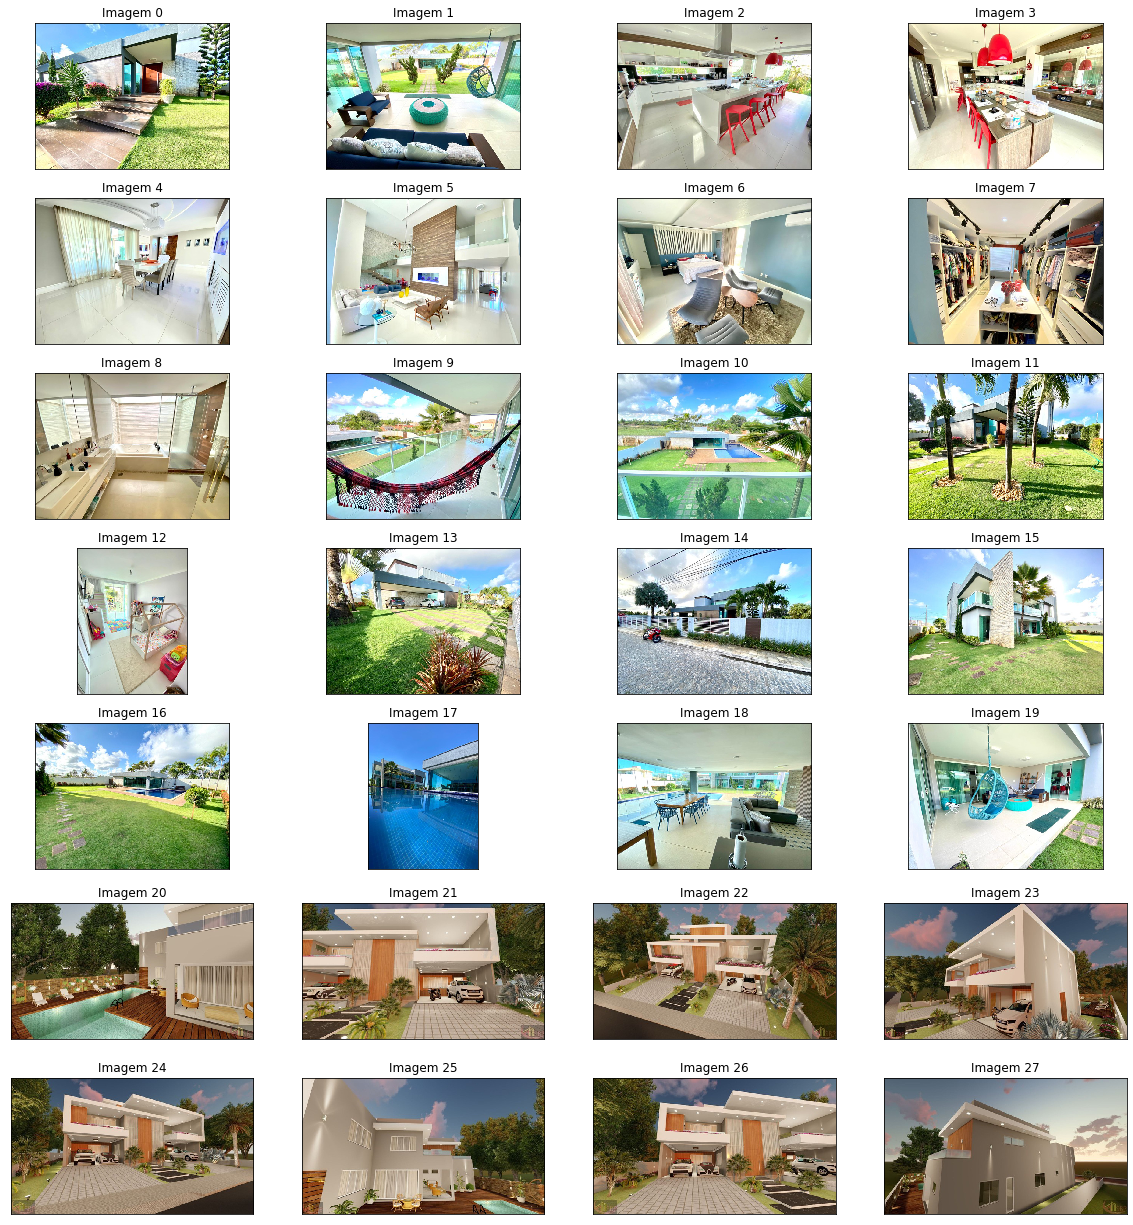

In [ ]:
imagens_exibidas = 30
qntd_colunas = 4
qntd_linhas = imagens_exibidas // qntd_colunas
qntd_imagens = len(lista_imagens)
if qntd_imagens % qntd_colunas > 0:
  qntd_linhas = qntd_linhas + 1

altura = (qntd_linhas * 3) + 1

plt.figure(figsize=(20, altura))
for i, img in enumerate(lista_imagens):
  if i == imagens_exibidas or i == qntd_imagens:
    break
  #Ler todas as imagens na pasta e plotar
  plt.subplot(qntd_linhas, qntd_colunas, i + 1)
  plt.imshow(img, interpolation='nearest')
  plt.title(f"Imagem {i}")
  plt.xticks(())
  plt.yticks(())
plt.show()

## Faz append com imagens já salvas

In [ ]:
from glob import glob
import os

path = '/content/drive/MyDrive/PIBIC/Precificando casas OLX/Pasta de Imagens Capturadas'
img_names = glob(os.path.join(path,'*.jpg'))
print(len(img_names))

3009


In [ ]:
print(img_names[-1])

/content/drive/MyDrive/PIBIC/Precificando casas OLX/Pasta de Imagens Capturadas/imov_001_img_009.jpg


In [ ]:
nome = img_names[-1].split('_')
nome

['/content/drive/MyDrive/PIBIC/Precificando casas OLX/Pasta de Imagens Capturadas/imov',
 '001',
 'img',
 '009.jpg']

In [ ]:
lista_num_imovel = []
for n in img_names:
  nome = int(n.split('_')[1])
  lista_num_imovel.append(nome)
lista_num_imovel.sort()
ultimo_imovel = lista_num_imovel[-1]
print(f"Número do último imóvel = {ultimo_imovel}, posição dele na lista = {ultimo_imovel-1}")

Número do último imóvel = 237, posição dele na lista = 236


In [ ]:
qtde_img_por_imovel_total = qtde_img_por_imovel_salvos + qtde_img_por_imovel
len(qtde_img_por_imovel_total)

280

## Salva a lista de Imagens

In [ ]:
np.array(qtde_img_por_imovel_total)

array([16, 20, 17, 16, 20,  4, 20, 19, 14, 19, 20,  2, 20, 20,  4,  3,  7,
       18, 16, 17, 18,  5, 20, 20, 18,  7, 16,  4,  1, 19, 18,  4, 19,  7,
        3, 20, 19,  6, 20, 20,  2,  7, 20, 20, 12, 14, 20, 20, 14,  9, 20,
       18, 20, 13,  7, 20, 14, 16, 20, 20, 13, 12, 14, 20, 16, 15,  6, 20,
       19,  8, 15, 20,  6, 11, 11, 13, 17,  6, 12, 20, 15, 20, 12, 13, 18,
       20, 20, 17, 17, 15,  6, 19, 20, 20, 20,  7, 13, 20,  6, 14,  3, 11,
       15, 14, 10, 20, 13, 11,  9, 10,  6,  9,  5, 17, 20, 20,  6,  4,  3,
       14, 20, 20, 11, 19, 19, 20, 13,  6, 20, 20, 20, 20, 20, 20,  6, 20,
       15, 20, 11, 11,  9, 13,  8,  7,  7, 18, 17, 14,  7,  7, 20,  8,  0,
        3, 10, 10, 10, 10, 10, 18,  5,  7,  9, 13,  5,  3, 19,  4, 10, 10,
       16,  5, 10,  7, 15, 14, 16, 16,  5,  7, 18,  7, 10,  5, 20,  5,  7,
        5, 13,  5, 11, 19,  5, 11,  6,  6, 14, 19, 20, 12, 12, 12, 15,  6,
        5,  8, 12,  8, 20,  6, 12, 13, 17,  4, 15, 18,  5, 11,  7,  0, 11,
       20, 20, 18, 20, 18

In [ ]:
# indice_imagem = 0
# for imovel in range(0, len(qtde_img_por_imovel_total)):
#   for img in range(1, qtde_img_por_imovel_total[imovel]+1):
#     if img < 10:
#       img = '00' + str(img)
#     elif img >= 10 and img < 100:
#       img = '0' + str(img)
    
#     # Como o imovel começa em 0 (index = numero do imóvel - 1) o intervalo é diferente do usado para numeração de imagem que inicia no 1
#     if imovel < 9:
#       num_imovel = '00' + str(imovel+1)
#     elif imovel >= 9 and imovel < 99:
#       num_imovel = '0' + str(imovel+1)
#     elif imovel >= 99 and imovel < 999:
#       num_imovel = str(imovel+1)
#     print(f"Imóvel_{num_imovel}_imagem_{img}   ------> indice = {indice_imagem}")
#     indice_imagem += 1

In [ ]:
# Verifica se os nomes das imagens estão adequados para salvar corretamente na pasta sem sobreescrever as imagens já salvas

# Mesmo q a ultima imagem n seja do ultimo imovel, significa q ele possui 0 imagens, o segundo for tb n irá rodar, pois vai
# ficar for de 1 até 0

indice_imagem = 0
for imovel in range(ultimo_imovel, len(qtde_img_por_imovel_total)):
  for img in range(1, qtde_img_por_imovel_total[imovel]+1):
    if img < 10:
      img = '00' + str(img)
    elif img >= 10 and img < 100:
      img = '0' + str(img)
    
    # Como o imovel começa em 0 (index = numero do imóvel - 1) o intervalo é diferente do usado para numeração de imagem que inicia no 1
    if imovel < 9:
      num_imovel = '00' + str(imovel+1)
    elif imovel >= 9 and imovel < 99:
      num_imovel = '0' + str(imovel+1)
    elif imovel >= 99 and imovel < 999:
      num_imovel = str(imovel+1)
    print(f"Imóvel_{num_imovel}_imagem_{img}   ------> indice = {indice_imagem}")
    indice_imagem += 1

Imóvel_238_imagem_001   ------> indice = 0
Imóvel_238_imagem_002   ------> indice = 1
Imóvel_238_imagem_003   ------> indice = 2
Imóvel_238_imagem_004   ------> indice = 3
Imóvel_238_imagem_005   ------> indice = 4
Imóvel_238_imagem_006   ------> indice = 5
Imóvel_238_imagem_007   ------> indice = 6
Imóvel_238_imagem_008   ------> indice = 7
Imóvel_238_imagem_009   ------> indice = 8
Imóvel_238_imagem_010   ------> indice = 9
Imóvel_238_imagem_011   ------> indice = 10
Imóvel_238_imagem_012   ------> indice = 11
Imóvel_238_imagem_013   ------> indice = 12
Imóvel_238_imagem_014   ------> indice = 13
Imóvel_238_imagem_015   ------> indice = 14
Imóvel_238_imagem_016   ------> indice = 15
Imóvel_238_imagem_017   ------> indice = 16
Imóvel_238_imagem_018   ------> indice = 17
Imóvel_238_imagem_019   ------> indice = 18
Imóvel_238_imagem_020   ------> indice = 19
Imóvel_239_imagem_001   ------> indice = 20
Imóvel_239_imagem_002   ------> indice = 21
Imóvel_239_imagem_003   ------> indice = 2

In [ ]:
# Impede a execução da seção por completo, para evitar erros de sobreesquever as imagens por engano

input("Deseja armazenar as imagens (y/n): ")

Deseja armazenar as imagens (y/n): y


'y'

In [ ]:
indice_imagem = 0
for imovel in range(ultimo_imovel, len(qtde_img_por_imovel_total)):
  for num_img in range(1, qtde_img_por_imovel_total[imovel]+1):
    imagem = np.asarray(lista_imagens[indice_imagem])

    if num_img < 10:
      img = '00' + str(num_img)
    elif num_img >= 10 and num_img < 100:
      img = '0' + str(num_img)
    
    # Como o imovel começa em 0 (index = numero do imóvel - 1) o intervalo é diferente do usado para numeração de imagem que inicia no 1
    if imovel < 9:
      num_imovel = '00' + str(imovel+1)
    elif imovel >= 9 and imovel < 99:
      num_imovel = '0' + str(imovel+1)
    elif imovel >= 99 and imovel < 999:
      num_imovel = str(imovel+1)

    path = '/content/drive/MyDrive/PIBIC/Precificando casas OLX/Pasta de Imagens Capturadas/imov_' + num_imovel + '_img_' + img + '.jpg'
    plt.imsave(path, imagem)
    indice_imagem += 1

In [ ]:
pd.DataFrame(qtde_img_por_imovel_total, columns=['Quantidade']).to_csv('/content/drive/MyDrive/PIBIC/Precificando casas OLX/Dados Capturados/qtde_imagens_por_imovel.csv', index=False)